In [ ]:
from google.colab import files
files.upload()


Saving hacklive2_dataset_complete.zip to hacklive2_dataset_complete.zip


In [ ]:
!unzip -q hacklive2_dataset_complete.zip
!pip install -q --upgrade seaborn

replace sample_submission_cxCGjdN.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

In [ ]:
ss = pd.read_csv('sample_submission_cxCGjdN.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
ID_COL, TARGET_COL = 'video_id', 'likes'

num_cols = ['views', 'dislikes', 'comment_count']
cat_cols = ['category_id', 'country_code']
text_cols = ['title', 'channel_title', 'tags', 'description']
date_cols = ['publish_date']

In [ ]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

**Steps to Make a Baseline Regression Model**

1. Concatenate/Join the train and test Datasets. All kinds of processing must be performed on both train and test datasets together.

2. Convert all Categorical Variables to numbers. We will be use OneHot Encoding for this. 

3. Fill Null Values. This can be followed by other data processing and feature engineering steps, but we will go into it later.

4. Split the dataset back into train and test datasets.

5. Split the train set into train and validation sets.

6. Fit a regression Model on train, check its results on validation set.

7. Predict for the test set.

8.  Save the submission as a csv file and submit the model on AV.

**1. Concating/Joining train and test datasets.**


In [ ]:
train.shape, test.shape

((26061, 12), (11170, 11))

In [ ]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)
df.shape

(37231, 12)

In [ ]:
df.head()

,video_id,title,channel_title,category_id,publish_date,tags,views,dislikes,comment_count,description,country_code,likes
0,53364,Alif Allah Aur Insaan Episode 34 HUM TV Drama ...,HUM TV,24.0,2017-12-12,"HUM|""TV""|""Alif Allah Aur Insaan""|""Episode 34""|...",351430.0,298.0,900.0,Alif Allah Aur Insaan Episode 34 Full - 12 Dec...,CA,2351.0
1,51040,It's Showtime Miss Q & A: Bela gets jealous of...,ABS-CBN Entertainment,24.0,2018-03-08,"ABS-CBN Entertainment|""ABS-CBN""|""ABS-CBN Onlin...",461508.0,74.0,314.0,Vice Ganda notices Bela Padilla's sudden chang...,CA,3264.0
2,1856,ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ \n ಕ್...,SANDALWOOD REVIEWS,24.0,2018-03-26,"challenging star darshan latest news|""challeng...",40205.0,150.0,100.0,ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ ಕ್ಲ...,IN,580.0
3,22618,Havana - swing cover | dodie feat. FLASHBACK,doddleoddle,10.0,2018-02-21,"havana|""cover""|""a capella""|""swing""|""dodie""|""fl...",509726.0,847.0,4536.0,Hi hi hi! here's our vid on FLASHBACK's channe...,GB,82773.0
4,74074,MUMMY NE NI KEHTA - 2 FT. 102 NOT OUT| DUDE S...,Dude Seriously,23.0,2018-05-10,"dude|""seriously""|""friends""|""fun""|""gujarati""|""h...",74311.0,69.0,161.0,BOOK YOUR TICKETS HERE: https://goo.gl/QxdSyg...,IN,3557.0



**2. Encoding categorical columns.**

There are multiple ways to encoded categorical variables. For the sake of simplicity, we will be using One-Hot Encoding.

In [ ]:
pd.get_dummies(pd.Series(['A', 'O', 'M']))

,A,M,O
0,1,0,0
1,0,0,1
2,0,1,0


In [ ]:
df = pd.get_dummies(df, columns = cat_cols)

In [ ]:
df.head(2)

,video_id,title,channel_title,publish_date,tags,views,dislikes,comment_count,description,likes,category_id_1.0,category_id_2.0,category_id_10.0,category_id_15.0,category_id_17.0,category_id_19.0,category_id_20.0,category_id_22.0,category_id_23.0,category_id_24.0,category_id_25.0,category_id_26.0,category_id_27.0,category_id_28.0,category_id_29.0,category_id_30.0,category_id_43.0,country_code_CA,country_code_GB,country_code_IN,country_code_US
0,53364,Alif Allah Aur Insaan Episode 34 HUM TV Drama ...,HUM TV,2017-12-12,"HUM|""TV""|""Alif Allah Aur Insaan""|""Episode 34""|...",351430.0,298.0,900.0,Alif Allah Aur Insaan Episode 34 Full - 12 Dec...,2351.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,51040,It's Showtime Miss Q & A: Bela gets jealous of...,ABS-CBN Entertainment,2018-03-08,"ABS-CBN Entertainment|""ABS-CBN""|""ABS-CBN Onlin...",461508.0,74.0,314.0,Vice Ganda notices Bela Padilla's sudden chang...,3264.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


**3. Filling Null Values**

As seen earlier in our EDA, our dataset contains null values. There could be multiple ways to fill our Null Values, but for now we will fill it with a large negative random number say -999

In [ ]:
df = df.fillna(-999)
df.isnull().sum().sum()

0

In [ ]:
df[num_cols + ['likes']] = df[num_cols + ['likes']].apply(lambda x: np.log1p(x))

In [ ]:
df['likes']

0         7.763021
1         8.091015
2         6.364751
3        11.323869
4         8.176954
           ...    
37226          NaN
37227          NaN
37228          NaN
37229          NaN
37230          NaN
Name: likes, Length: 37231, dtype: float64

**4. Split the processed dataset back into train and test datasets.**

The first train.shape[0] of df are rows that belong to train and the rest are those that belong to test

In [ ]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [ID_COL, TARGET_COL]]

**5. Split the train set into train and validation sets.**

We will use 80-20 split with 80% of the rows belonging to training data. Stratified Sampling is necessary, since the dataset is highly imbalanced. Stratified sampling ensures that the minority class is distributed proportionally among the two classes.

In [ ]:
trn, val = train_test_split(train_proc, test_size=0.2, random_state = 1)

###### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

###### Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Features for the test data that we will be predicting
X_test = test_proc[features]

**6. Fit a regression Model on train, check its results on validation set.**

In [ ]:

from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

def av_metric(y_true, y_pred):
  return 1000 * np.sqrt(mean_squared_error(y_true, y_pred))

**Only Numerical Columns**

In [ ]:
clf = LinearRegression()

_ = clf.fit(X_trn[num_cols], y_trn)

preds_val = clf.predict(X_val[num_cols])

av_metric_score = av_metric(y_val, preds_val)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 949.5701548787257


In [ ]:
preds_test = clf.predict(X_test[num_cols])

preds_test = np.expm1(preds_test)

download_preds(preds_test, 'lr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pd.read_csv('lr.csv')

,video_id,likes
0,87185,699.336920
1,9431,2703.969243
2,40599,61.167703
3,494,2068.652873
4,73942,1616.879332
...,...,...
11165,19415,2124.039869
11166,25168,3706.544106
11167,80293,5354.955513
11168,80880,20543.033487


**Numerical Columns + Categorical Columns**

In [ ]:
X_trn.columns

Index(['title', 'channel_title', 'publish_date', 'tags', 'views', 'dislikes',
       'comment_count', 'description', 'category_id_1.0', 'category_id_2.0',
       'category_id_10.0', 'category_id_15.0', 'category_id_17.0',
       'category_id_19.0', 'category_id_20.0', 'category_id_22.0',
       'category_id_23.0', 'category_id_24.0', 'category_id_25.0',
       'category_id_26.0', 'category_id_27.0', 'category_id_28.0',
       'category_id_29.0', 'category_id_30.0', 'category_id_43.0',
       'country_code_CA', 'country_code_GB', 'country_code_IN',
       'country_code_US'],
      dtype='object')

In [ ]:
features = [c for c in X_trn.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in text_cols + date_cols]

In [ ]:
clf = LinearRegression()

_ = clf.fit(X_trn[cat_num_cols], y_trn)

preds_val = clf.predict(X_val[cat_num_cols])

av_metric_score = av_metric(y_val, preds_val)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 873.0627392234118


In [ ]:
preds_test = clf.predict(X_test[cat_num_cols])

preds_test = np.expm1(preds_test)

download_preds(preds_test, 'lr_num_cat.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pd.read_csv('lr_num_cat.csv')

,video_id,likes
0,87185,619.274464
1,9431,2248.410381
2,40599,59.060247
3,494,3895.071896
4,73942,1438.234155
...,...,...
11165,19415,1878.938060
11166,25168,3850.642023
11167,80293,3957.385411
11168,80880,10859.721258


In [ ]:
clf = DecisionTreeRegressor(random_state=2)

_ = clf.fit(X_trn[cat_num_cols], y_trn)

preds_val = clf.predict(X_val[cat_num_cols])

av_metric_score = av_metric(y_val, preds_val)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 933.7445026402412


# **Hyperparameter Tuning**

In our decision tree model earlier, we did not change any of the parameters that were input to our model. However hyper-parameters and their values vary from dataset to dataset, and their optimal values have a large impact on the performance of our model.

To perform hyperparameter-tuning we specify a list of hyper-parameters to tune and their possible values.

For example:
```
max_depth: [6, 9, 12, 15]
learning_rate: [0.0001, 0.005, 0.01, 0.05]
```

etc.

## **1. Grid Search**

In grid search we try all possible combinations from the values of hyperparameters provided, to find the optimal hyper-parameter combination. However as the number of hyperparameters and their possible values grows, doing a grid search becomes infeasible.

Consider there are 5 hyperparameters to tune, and each of them 5 have different possible values.

Then total possible combinations of hyperparameters will be:

5 x 5 x 5 x 5 x 5 = 3125.

So you will have to wait for your model to run 3125 times, before getting the optimal set of hyperparameters.

If you still think you want to run it these many times, you are most welcome :)


# **2. Random Search**

In random search we will run our model only a fixed number of times, say 10, and among these 10 runs we will return the best hyper-parameter combination. Yes, you are right, this may not be the optimal hyper-parameter combination. But, it saves much more time, so we will go for random search.

In [ ]:


from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
}

clf = RandomizedSearchCV(DecisionTreeRegressor(),
                         hyperparam_combs,
                         scoring='neg_root_mean_squared_error',
                         random_state=1,
                         n_iter=20)

search = clf.fit(train_proc[cat_num_cols], train_proc[TARGET_COL])

search.best_params_

{'max_depth': 12,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 2}

In [ ]:
best_params = {'max_depth': 12,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'random_state': 1,
 'min_samples_split': 2}

clf = DecisionTreeRegressor(**best_params)

_ = clf.fit(X_trn[cat_num_cols], y_trn)

preds_val = clf.predict(X_val[cat_num_cols])

av_metric_score = av_metric(y_val, preds_val)

print(f'AV metric score is: {av_metric_score}')

AV metric score is: 766.018775496316


In [ ]:
preds_test = clf.predict(X_test[cat_num_cols])

preds_test = np.expm1(preds_test)

download_preds(preds_test, 'dt_num_cat.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pd.read_csv('dt_num_cat.csv')

,video_id,likes
0,87185,568.562640
1,9431,1838.380902
2,40599,93.315782
3,494,4189.844435
4,73942,1388.870653
...,...,...
11165,19415,1620.553722
11166,25168,5752.247223
11167,80293,5752.247223
11168,80880,16723.248206


# **Validation Strategy.**

**Problems with simple train_test_split validation**

* We are not using complete 100 % of the dataset for training. More data implies more performance, if the data quality is good.

* We are not using complete 100 % of the dataset for validation. Our validation now is biased towards the validation set we have got through train_test_split. What if the test set is different from the validation set ?


## **K-Fold Validation**



K Fold validation splits the dataset into K-parts or K-splits.

Suppose we are performing a 5-fold validation. Thus we split the training dataset into 5 parts. Each of these will contain 20 % of the dataset.


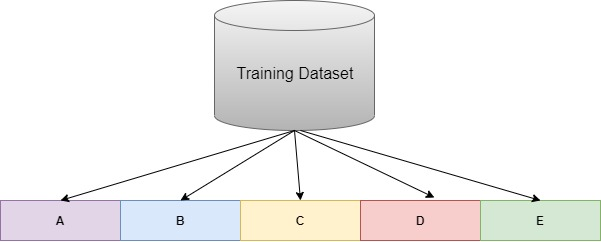

Now for each of these parts, we take them as validation one by one and rest of the parts for training. The unshaded or white box, represents the part among A, B, C, D, and E, that we take for validation. Rest are used for training in that particular fold.
Then we make two predictions (shown in the right hand side of the diagram):

**1. Predictions for the validation set:** This is also known as out-of-fold prediction.

**2. Predictions for the test set:** This is the dataset for which we need to submit our predictions to AV.

Finally if we combine the predictions for each of these folds we get OOFs or Out-of-Folds predictions. This is the prediction for the entire dataset. We can now see the performance our classifier on the entire training set.

Also we take the mean of the test predictions for each fold, and get our final test_predictions. We then need to round it to 0 or 1, since our metric demands we submit a discrete output, ie. no probabilities. 

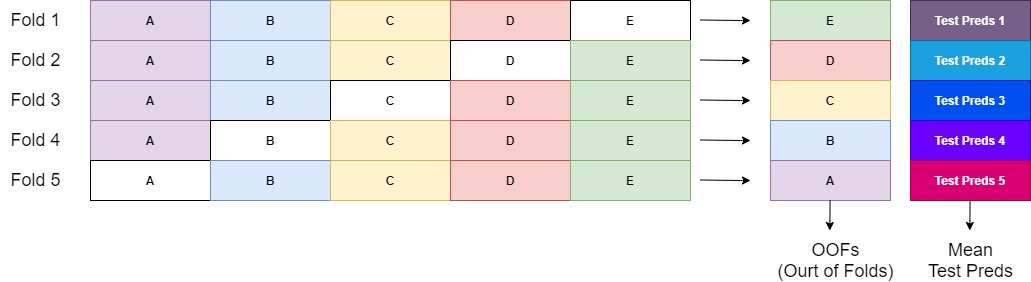

## **Stratified K-Fold.**

One obvious problem with normal KFold, is that each in each fold the distribution of samples in the validation set, will be not be same. This is a big problem with imbalanced datasets. 

In our above example its possible that in any of the splits we could have could have a validation set having all samples with less number of likes

To overcome this problem we will use Stratified-KFold Validation. StratifiedKFold ensures that each of the splits have same proportion of examples of each type



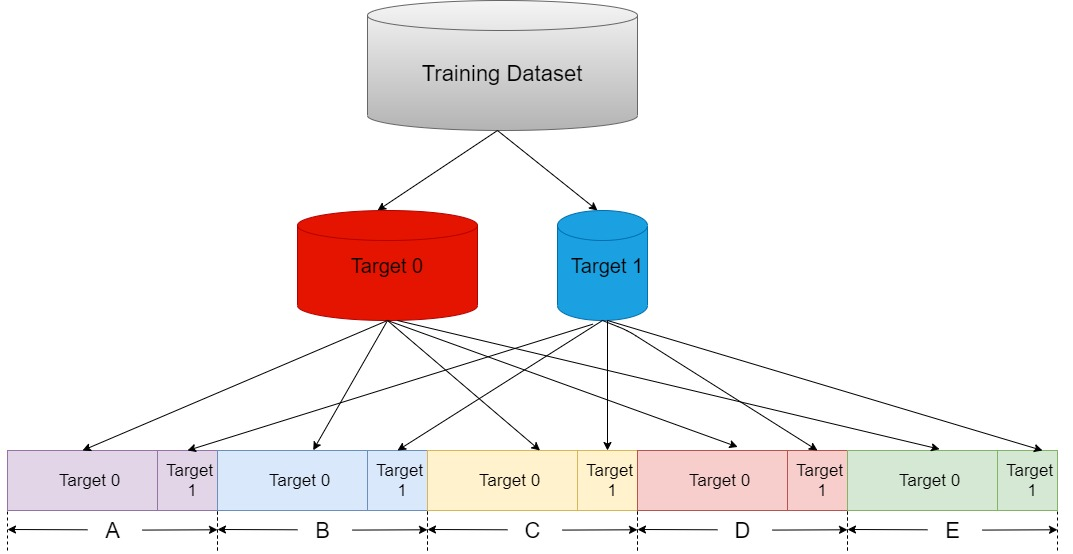

On a side note seeing so many arrows, reminds of Neural Networks.

Lets make our Decision Tree Model with Stratified KFold Validation

**Function to Run StratifiedKFold**

In [ ]:
pd.qcut(np.arange(10), 5, labels = False, duplicates='drop')

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  return oofs, preds

**KFold on Decision Tree**

In [ ]:
dt_params = {'max_depth': 12,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 2}

clf = DecisionTreeRegressor(**dt_params)
        

dt_oofs, dt_preds = run_clf_kfold(clf, train_proc, test_proc, cat_num_cols)


------------- Fold 1 -------------

AV metric score for validation set is 772.8277838320226

------------- Fold 2 -------------

AV metric score for validation set is 768.0567612828382

------------- Fold 3 -------------

AV metric score for validation set is 754.0996782005626

------------- Fold 4 -------------

AV metric score for validation set is 765.8166071386306

------------- Fold 5 -------------

AV metric score for validation set is 763.5381985833818


AV metric for oofs is 764.8932336098103


**Submitting on the Leaderboard**

In [ ]:
dt_preds_t = np.expm1(dt_preds)
download_preds(dt_preds_t, file_name = 'hacklive_dt_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Gradient Boosting**

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

https://en.wikipedia.org/wiki/Gradient_boosting

https://www.analyticsvidhya.com/blog/2020/02/4-boosting-algorithms-machine-learning/

Most Popular Variants of GradientBoosting
----------------------------

1. LightGBM

2. XGBoost

3. CatBoost

 ## **LightGBM**

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.

* Lower memory usage.

* Better accuracy.

* Support of parallel and GPU learning.

* Capable of handling large-scale data.

https://lightgbm.readthedocs.io/en/latest/

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
clf = LGBMRegressor()
lgb_oofs, lgb_preds = run_clf_kfold(clf, train_proc, test_proc, cat_num_cols)


------------- Fold 1 -------------

AV metric score for validation set is 674.7737515393275

------------- Fold 2 -------------

AV metric score for validation set is 678.3212622895253

------------- Fold 3 -------------

AV metric score for validation set is 669.5119539218649

------------- Fold 4 -------------

AV metric score for validation set is 665.6236530707358

------------- Fold 5 -------------

AV metric score for validation set is 671.8950668383243


AV metric for oofs is 672.0393057033824


**Submitting on the Leaderboard**

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Tuning LightGBM**

* Early Stopping: Stopping the model training, when the model starts to overfit
  * How do we know if model is overfitting ?
* HyperParameter Optimization.
  * Is random search the best way to go ?

**Simple Function to Run Gradient Boosting**

Let's make a simple function to call gradient boosting and get our oofs and predictions. Rather than copying and pasting the same code again and again/

In [ ]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train_proc))
  preds = np.zeros((len(test_proc)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi

**Manual Tuning. Choosing Hyperparameters to Tune**


------------- Fold 1 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.688058
[200]	valid_0's rmse: 0.673056
[300]	valid_0's rmse: 0.668448
[400]	valid_0's rmse: 0.666901
[500]	valid_0's rmse: 0.666187
[600]	valid_0's rmse: 0.666155
[700]	valid_0's rmse: 0.665891
[800]	valid_0's rmse: 0.666161
Early stopping, best iteration is:
[733]	valid_0's rmse: 0.665611

AV metric score for validation set is 665.6109435506439

------------- Fold 2 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.689594
[200]	valid_0's rmse: 0.676902
[300]	valid_0's rmse: 0.673678
[400]	valid_0's rmse: 0.672131
[500]	valid_0's rmse: 0.672627
Early stopping, best iteration is:
[406]	valid_0's rmse: 0.672039

AV metric score for validation set is 672.0387821770701

------------- Fold 3 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.684084
[200]	valid_0's rmse: 0

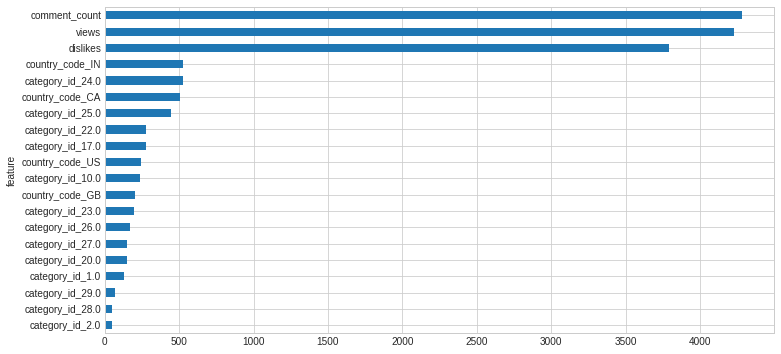

In [ ]:
clf = LGBMRegressor(n_estimators = 1000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )
fit_params = {'verbose': 100, 'early_stopping_rounds': 100, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

**Submitting on the Leaderboard**

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_5_folds_tuned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Tuning Learning Rate**


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.721861
[600]	valid_0's rmse: 0.684465
[900]	valid_0's rmse: 0.675775
[1200]	valid_0's rmse: 0.671939
[1500]	valid_0's rmse: 0.669667
[1800]	valid_0's rmse: 0.668281
[2100]	valid_0's rmse: 0.667301
[2400]	valid_0's rmse: 0.66692
[2700]	valid_0's rmse: 0.666468
[3000]	valid_0's rmse: 0.666088
[3300]	valid_0's rmse: 0.665889
Early stopping, best iteration is:
[3258]	valid_0's rmse: 0.66583

AV metric score for validation set is 665.8296103716714

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.721827
[600]	valid_0's rmse: 0.687805
[900]	valid_0's rmse: 0.680174
[1200]	valid_0's rmse: 0.676595
[1500]	valid_0's rmse: 0.674976
[1800]	valid_0's rmse: 0.673857
[2100]	valid_0's rmse: 0.673691
Early stopping, best iteration is:
[2034]	valid_0's rmse: 0.67356

AV metric score for validation set is 673.5

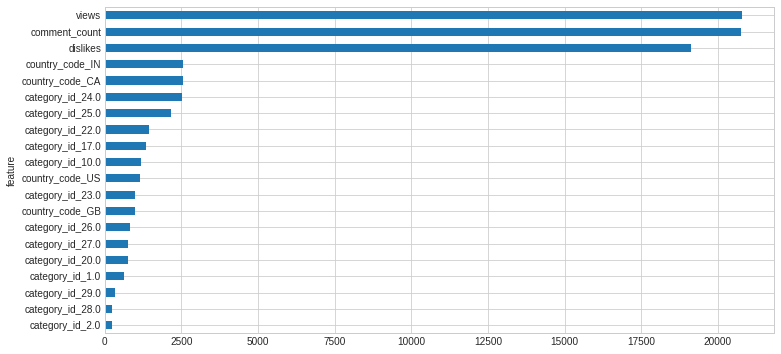

In [ ]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

**Submitting on the Leaderboard**

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_5_folds_tuned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **CatBoost**

CatBoost is a high-performance open source library for gradient boosting on decision trees.

Features

* Great quality without parameter tuning: Reduce time spent on parameter tuning, because CatBoost provides great results with default parameters

* Categorical features support: Improve your training results with CatBoost that allows you to use non-numeric factors, instead of having to pre-process your data or spend time and effort turning it to numbers.

* Fast and scalable GPU version: Train your model on a fast implementation of gradient-boosting algorithm for GPU. Use a multi-card configuration for large datasets.

* Improved accuracy: Reduce overfitting when constructing your models with a novel gradient-boosting scheme.

* Fast prediction: Apply your trained model quickly and efficiently even to latency-critical tasks using CatBoost's model applier

https://catboost.ai/


------------- Fold 1 -------------
0:	learn: 1.9161623	test: 1.9077476	best: 1.9077476 (0)	total: 11.1ms	remaining: 33.2s
200:	learn: 0.8395688	test: 0.8496237	best: 0.8496237 (200)	total: 900ms	remaining: 12.5s
400:	learn: 0.7310593	test: 0.7459856	best: 0.7459856 (400)	total: 1.76s	remaining: 11.4s
600:	learn: 0.7071283	test: 0.7225519	best: 0.7225519 (600)	total: 2.66s	remaining: 10.6s
800:	learn: 0.6931874	test: 0.7085013	best: 0.7085013 (800)	total: 3.5s	remaining: 9.61s
1000:	learn: 0.6828767	test: 0.6984767	best: 0.6984767 (1000)	total: 4.35s	remaining: 8.68s
1200:	learn: 0.6741208	test: 0.6901979	best: 0.6901979 (1200)	total: 5.18s	remaining: 7.76s
1400:	learn: 0.6664207	test: 0.6833039	best: 0.6833039 (1400)	total: 6.04s	remaining: 6.89s
1600:	learn: 0.6604077	test: 0.6785152	best: 0.6785152 (1600)	total: 6.89s	remaining: 6.02s
1800:	learn: 0.6554195	test: 0.6750037	best: 0.6750022 (1798)	total: 7.75s	remaining: 5.16s
2000:	learn: 0.6510266	test: 0.6720600	best: 0.6720600 (20

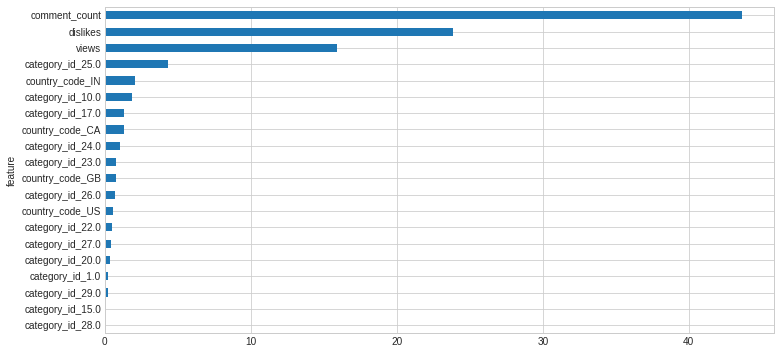

In [ ]:
clf = CatBoostRegressor(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

**Submitting on the Leaderboard**

In [ ]:
cb_preds_t = np.expm1(cb_preds)
download_preds(cb_preds_t, file_name = 'hacklive_cb_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pd.read_csv('hacklive_cb_folds.csv')

,video_id,likes
0,87185,620.776036
1,9431,2224.582218
2,40599,66.015509
3,494,3590.268024
4,73942,1013.820616
...,...,...
11165,19415,1326.371005
11166,25168,5228.239236
11167,80293,6845.730614
11168,80880,7252.059914


**CatBoost: gives Visible Improvement.**

* Is catboost better then LightGBM ?
* Can catboost score be further improved ?
* Can LighGBM be tuned to give a better score than CatBoost ?

## **XGBoost**

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

https://xgboost.readthedocs.io/en/latest/


------------- Fold 1 -------------
[07:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.13914
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.675344
[400]	validation_0-rmse:0.668702
[600]	validation_0-rmse:0.666931
[800]	validation_0-rmse:0.666898
Stopping. Best iteration:
[736]	validation_0-rmse:0.666675


AV metric score for validation set is 666.6752519026531

------------- Fold 2 -------------
[07:37:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.12698
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.687736
[400]	validation_0-rmse:0.680454
[600]	validation_0-rmse:0.679159
[800]	validation_0-rmse:0.678962
Stopping. Best iteration:
[790]	validation_0-rmse:0.678721


AV metric score for validation set is 67

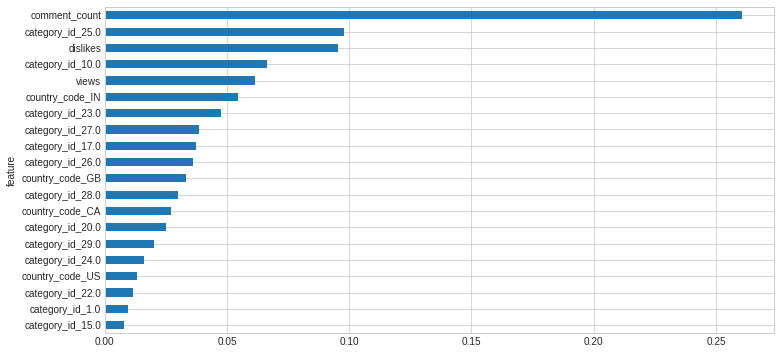

In [ ]:
clf = XGBRegressor(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

**Submitting on the Leaderboard**

In [ ]:
xgb_preds_t = np.expm1(xgb_preds)
download_preds(xgb_preds_t, file_name = 'hacklive_xgb_5_folds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Questions to think about XGBoost**

* Is XGBoost worse than LightGBM and CatBoost ?

* Can XGBoost be tuned more ?



# **Feature Engineering**

* What does a model know about a sample ?

* What the model does not know about the sample ?

* How do we provide that unknown information to the model ?


***Feature Engineering is one of the biggest difference maker in any ML competition.*** 

<br>
<br>

**Helper Functions**

In [ ]:
def join_df(train, test):

  df = pd.concat([train, test], axis=0).reset_index(drop = True)
  features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
  df[num_cols + ['likes']] = df[num_cols + ['likes']].apply(lambda x: np.log1p(x))

  return df, features

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
  
  return train, test, features

In [ ]:
df, features = join_df(train, test)

In [ ]:
cat_cols = ['category_id', 'country_code', 'channel_title']

**Why Label Encoding ?**

In [ ]:
### Label Encoding
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])

**DATE TIME FEATURES**

In [ ]:
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y-%m-%d')
df['publish_date_days_since_start'] = (df['publish_date'] - df['publish_date'].min()).dt.days

df['publish_date_day_of_week'] = df['publish_date'].dt.dayofweek
df['publish_date_year'] = df['publish_date'].dt.year
df['publish_date_month'] = df['publish_date'].dt.month

In [ ]:
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

In [ ]:
cat_num_cols

['channel_title',
 'category_id',
 'views',
 'dislikes',
 'comment_count',
 'country_code',
 'publish_date_days_since_start',
 'publish_date_day_of_week',
 'publish_date_year',
 'publish_date_month']

In [ ]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.632226
[600]	valid_0's rmse: 0.61216
[900]	valid_0's rmse: 0.603608
[1200]	valid_0's rmse: 0.598652
[1500]	valid_0's rmse: 0.596547
[1800]	valid_0's rmse: 0.594728
[2100]	valid_0's rmse: 0.593298
[2400]	valid_0's rmse: 0.592479
[2700]	valid_0's rmse: 0.591633
Early stopping, best iteration is:
[2632]	valid_0's rmse: 0.591455

AV metric score for validation set is 591.4551038851612

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.641797
[600]	valid_0's rmse: 0.62382
[900]	valid_0's rmse: 0.613848
[1200]	valid_0's rmse: 0.609342
[1500]	valid_0's rmse: 0.606363
[1800]	valid_0's rmse: 0.604763
[2100]	valid_0's rmse: 0.603543
[2400]	valid_0's rmse: 0.603089
[2700]	valid_0's rmse: 0.603023
Early stopping, best iteration is:
[2589]	valid_0's rmse: 0.602773

AV metric score for validation set is 602.

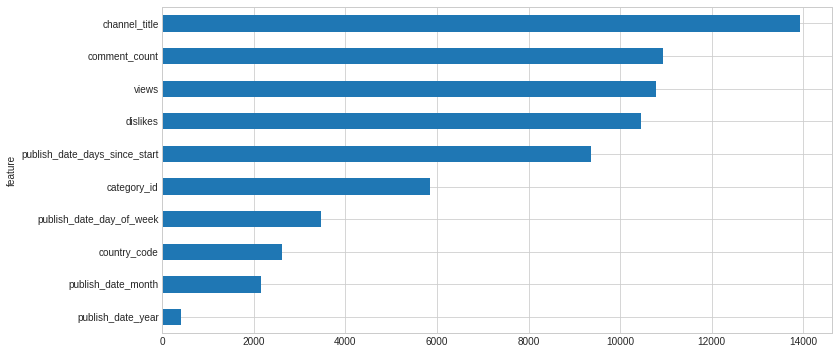

In [ ]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

**Submitting on the Leaderboard**

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_fe.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pd.read_csv('hacklive_lgb_fe.csv')

,video_id,likes
0,87185,568.235862
1,9431,2066.377645
2,40599,37.649187
3,494,3757.871204
4,73942,741.771063
...,...,...
11165,19415,1540.362329
11166,25168,4155.892593
11167,80293,7949.698768
11168,80880,6206.966633


## **Frequency Features**

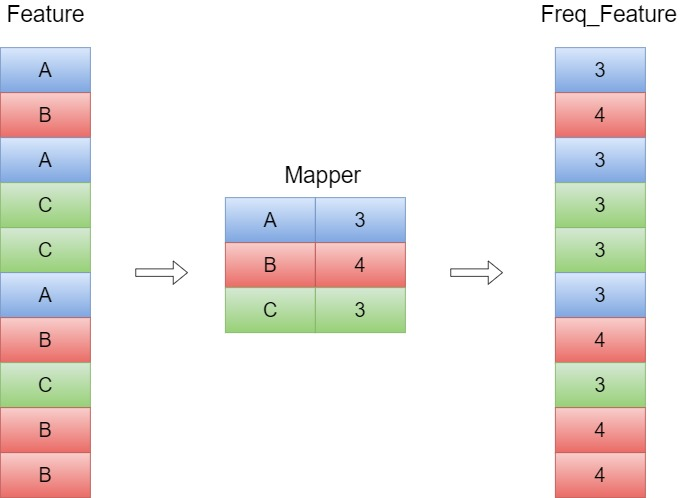

**Encoding Channel Title**

In [ ]:
df['channel_title'].nunique()

6979

In [ ]:
df['channel_title'].value_counts()

116     233
299     180
15      179
92      169
406     152
       ... 
3832      1
5883      1
5551      1
1453      1
4078      1
Name: channel_title, Length: 6979, dtype: int64

In [ ]:

df['publish_date'].value_counts()

2018-01-29    282
2017-12-13    258
2018-01-19    257
2017-12-20    255
2018-01-12    255
             ... 
2017-10-27      1
2013-10-27      1
2015-03-29      1
2011-02-03      1
2013-03-20      1
Name: publish_date, Length: 399, dtype: int64

In [ ]:
df['channel_title_num_videos'] = df['channel_title'].map(df['channel_title'].value_counts())
df['publish_date_num_videos'] = df['publish_date'].map(df['publish_date'].value_counts())

In [ ]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

In [ ]:
cat_num_cols

['channel_title',
 'category_id',
 'views',
 'dislikes',
 'comment_count',
 'country_code',
 'publish_date_days_since_start',
 'publish_date_day_of_week',
 'publish_date_year',
 'publish_date_month',
 'channel_title_num_videos',
 'publish_date_num_videos']


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.606433
[600]	valid_0's rmse: 0.582532
[900]	valid_0's rmse: 0.570429
[1200]	valid_0's rmse: 0.564703
[1500]	valid_0's rmse: 0.560397
[1800]	valid_0's rmse: 0.558502
[2100]	valid_0's rmse: 0.557166
[2400]	valid_0's rmse: 0.556729
[2700]	valid_0's rmse: 0.555346
[3000]	valid_0's rmse: 0.554132
Early stopping, best iteration is:
[3076]	valid_0's rmse: 0.553943

AV metric score for validation set is 553.9432465904889

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.613426
[600]	valid_0's rmse: 0.589525
[900]	valid_0's rmse: 0.578287
[1200]	valid_0's rmse: 0.572217
[1500]	valid_0's rmse: 0.568607
[1800]	valid_0's rmse: 0.566672
[2100]	valid_0's rmse: 0.564948
[2400]	valid_0's rmse: 0.563426
[2700]	valid_0's rmse: 0.561754
Early stopping, best iteration is:
[2782]	valid_0's rmse: 0.561517

AV metri

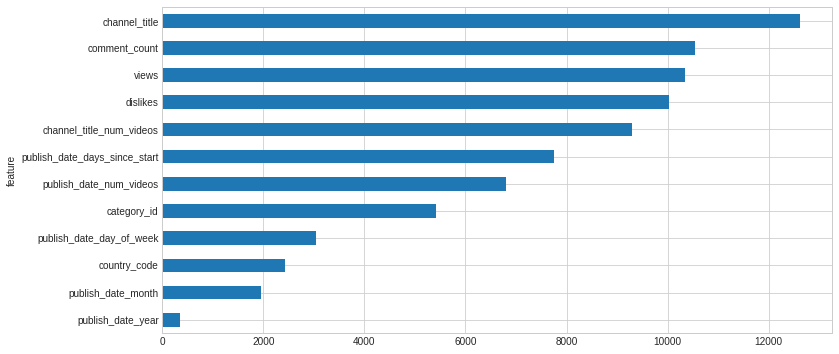

In [ ]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

**Submitting on the Leaderboard**

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_fe_num_videos.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df['channel_in_n_countries'] = df.groupby('channel_title')['country_code'].transform('nunique')

In [ ]:
df['channel_in_n_countries'].unique()

array([2, 1, 3, 4])

In [ ]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.602211
[600]	valid_0's rmse: 0.576537
[900]	valid_0's rmse: 0.564352
[1200]	valid_0's rmse: 0.557464
[1500]	valid_0's rmse: 0.553461
[1800]	valid_0's rmse: 0.550827
[2100]	valid_0's rmse: 0.549391
[2400]	valid_0's rmse: 0.548714
[2700]	valid_0's rmse: 0.547864
[3000]	valid_0's rmse: 0.547396
[3300]	valid_0's rmse: 0.547002
Early stopping, best iteration is:
[3238]	valid_0's rmse: 0.546874

AV metric score for validation set is 546.8742825264334

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.606165
[600]	valid_0's rmse: 0.584343
[900]	valid_0's rmse: 0.574279
[1200]	valid_0's rmse: 0.567945
[1500]	valid_0's rmse: 0.563975
[1800]	valid_0's rmse: 0.561168
[2100]	valid_0's rmse: 0.559567
[2400]	valid_0's rmse: 0.557947
[2700]	valid_0's rmse: 0.557585
Early stopping, best iteration is:
[2535]	va

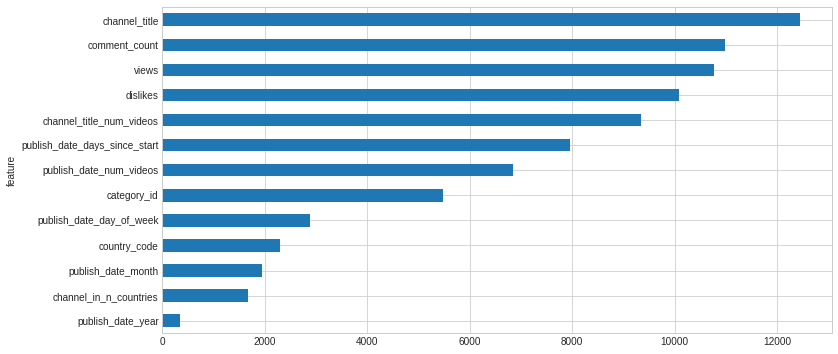

In [ ]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

**Submitting on the Leaderboard**

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds, file_name = 'hacklive_lgb_fe_num_videos.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Grouping Features**

In [ ]:
df['channel_title_mean_views'] = df.groupby('channel_title')['views'].transform('mean')
df['channel_title_max_views'] = df.groupby('channel_title')['views'].transform('max')
df['channel_title_min_views'] = df.groupby('channel_title')['views'].transform('min')

df['channel_title_mean_comments'] = df.groupby('channel_title')['comment_count'].transform('mean')
df['channel_title_max_comments'] = df.groupby('channel_title')['comment_count'].transform('max')
df['channel_title_min_comments'] = df.groupby('channel_title')['comment_count'].transform('min')

**Exercise**

Try the same thing for dislikes

In [ ]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.578641
[600]	valid_0's rmse: 0.550924
[900]	valid_0's rmse: 0.538777
[1200]	valid_0's rmse: 0.532383
[1500]	valid_0's rmse: 0.528351
[1800]	valid_0's rmse: 0.525448
[2100]	valid_0's rmse: 0.524152
[2400]	valid_0's rmse: 0.523314
[2700]	valid_0's rmse: 0.521987
[3000]	valid_0's rmse: 0.520882
[3300]	valid_0's rmse: 0.520304
[3600]	valid_0's rmse: 0.520127
Early stopping, best iteration is:
[3526]	valid_0's rmse: 0.519849

AV metric score for validation set is 519.8493600322406

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.574392
[600]	valid_0's rmse: 0.550968
[900]	valid_0's rmse: 0.539383
[1200]	valid_0's rmse: 0.53289
[1500]	valid_0's rmse: 0.529778
[1800]	valid_0's rmse: 0.527363
[2100]	valid_0's rmse: 0.52631
[2400]	valid_0's rmse: 0.525168
Early stopping, best iteration is:
[2473]	vali

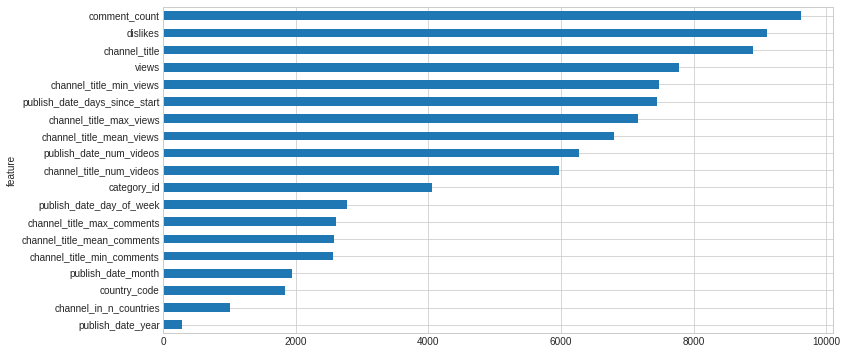

In [ ]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

**Submitting on the Leaderboard**

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_fe_num_videos.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pd.read_csv('hacklive_lgb_fe_num_videos.csv')

,video_id,likes
0,87185,671.470159
1,9431,2729.480660
2,40599,27.221996
3,494,4137.366711
4,73942,731.186122
...,...,...
11165,19415,1695.911559
11166,25168,2700.709884
11167,80293,8886.276343
11168,80880,5386.435125


**Exericse**

Do the same thing for dislikes

**Feature Selection**

**Feature Engineering for Text Data**

**Length of Text Columns**

In [ ]:
df['title_len'] = df['title'].apply(lambda x: len(x))
df['description_len'] = df['description'].apply(lambda x: len(x))
df['tags_len'] = df['tags'].apply(lambda x: len(x))

In [ ]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.572801
[600]	valid_0's rmse: 0.547272
[900]	valid_0's rmse: 0.536678
[1200]	valid_0's rmse: 0.529745
[1500]	valid_0's rmse: 0.524954
[1800]	valid_0's rmse: 0.521299
[2100]	valid_0's rmse: 0.519362
[2400]	valid_0's rmse: 0.517661
[2700]	valid_0's rmse: 0.517014
[3000]	valid_0's rmse: 0.516263
[3300]	valid_0's rmse: 0.515659
[3600]	valid_0's rmse: 0.515419
[3900]	valid_0's rmse: 0.515181
[4200]	valid_0's rmse: 0.514753
[4500]	valid_0's rmse: 0.514438
[4800]	valid_0's rmse: 0.514103
Did not meet early stopping. Best iteration is:
[4909]	valid_0's rmse: 0.513974

AV metric score for validation set is 513.974448832514

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.569932
[600]	valid_0's rmse: 0.544317
[900]	valid_0's rmse: 0.531647
[1200]	valid_0's rmse: 0.525217
[1500]	valid_0's rmse: 0.520719


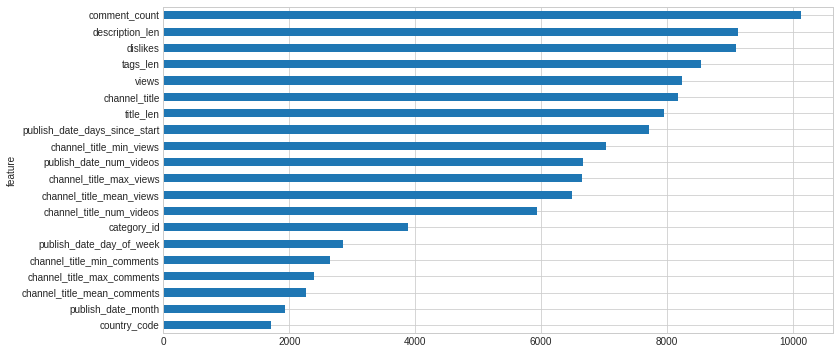

In [ ]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

**Submitting on the Leaderboard**

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_text_cols_len.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Bag of Words Approach for Text Based Features**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
?CountVectorizer

In [ ]:
TOP_N_WORDS = 50

vec = CountVectorizer(max_features = TOP_N_WORDS)
txt_to_fts = vec.fit_transform(df['description']).toarray()
txt_to_fts.shape

(37231, 50)

In [ ]:
c = 'description'
txt_fts_names = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_names] = txt_to_fts

train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.548607
[600]	valid_0's rmse: 0.528758
[900]	valid_0's rmse: 0.517733
[1200]	valid_0's rmse: 0.511368
[1500]	valid_0's rmse: 0.506014
[1800]	valid_0's rmse: 0.50231
[2100]	valid_0's rmse: 0.500013
[2400]	valid_0's rmse: 0.498206
[2700]	valid_0's rmse: 0.49724
[3000]	valid_0's rmse: 0.495802
[3300]	valid_0's rmse: 0.495164
[3600]	valid_0's rmse: 0.494546
[3900]	valid_0's rmse: 0.493731
[4200]	valid_0's rmse: 0.492816
[4500]	valid_0's rmse: 0.492496
[4800]	valid_0's rmse: 0.492249
Did not meet early stopping. Best iteration is:
[4995]	valid_0's rmse: 0.49205

AV metric score for validation set is 492.0503371800835

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.548168
[600]	valid_0's rmse: 0.52543
[900]	valid_0's rmse: 0.515111
[1200]	valid_0's rmse: 0.509496
[1500]	valid_0's rmse: 0.505306
[18

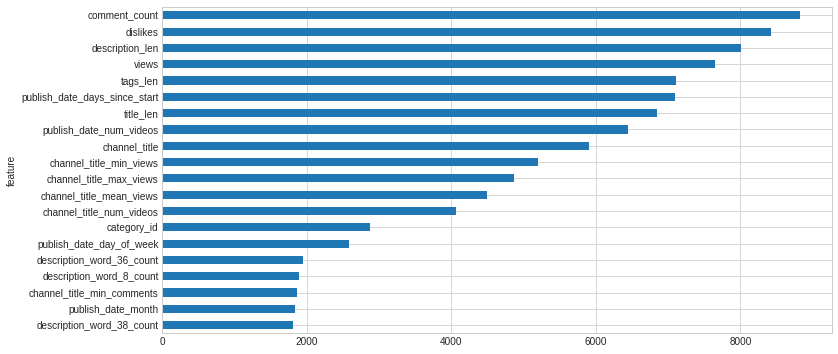

In [ ]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

**Submitting on the Leaderboard**

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_text_cols_bow.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Exercise**

Apply the same BOW approach to the other text cols in the  model.

**Advanced**

Try to read about state of the art models used for Classification/Regression in NLP. Can you implement them ?

**Feature Selection**

* **When is feature selection required ?**
* **Should I focus my time in feature selection or feature engineering?**

In [ ]:
fi

feature
description_word_38_count        1812.4
publish_date_month               1838.8
channel_title_min_comments       1866.4
description_word_8_count         1887.2
description_word_36_count        1949.2
publish_date_day_of_week         2580.8
category_id                      2873.2
channel_title_num_videos         4059.0
channel_title_mean_views         4491.2
channel_title_max_views          4865.4
channel_title_min_views          5204.2
channel_title                    5904.2
publish_date_num_videos          6443.4
title_len                        6847.2
publish_date_days_since_start    7096.2
tags_len                         7108.0
views                            7653.0
description_len                  8008.6
dislikes                         8428.4
comment_count                    8824.6
Name: importance, dtype: float64

In [ ]:
to_drop_cols = ['views']

In [ ]:
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date'] + to_drop_cols]

In [ ]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.593832
[600]	valid_0's rmse: 0.570681
[900]	valid_0's rmse: 0.561119
[1200]	valid_0's rmse: 0.5552
[1500]	valid_0's rmse: 0.551433
[1800]	valid_0's rmse: 0.548114
[2100]	valid_0's rmse: 0.546018
[2400]	valid_0's rmse: 0.544959
[2700]	valid_0's rmse: 0.544361
[3000]	valid_0's rmse: 0.543896
[3300]	valid_0's rmse: 0.543547
[3600]	valid_0's rmse: 0.543055
[3900]	valid_0's rmse: 0.542685
[4200]	valid_0's rmse: 0.542539
Early stopping, best iteration is:
[4121]	valid_0's rmse: 0.542479

AV metric score for validation set is 542.4788742796687

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.588803
[600]	valid_0's rmse: 0.567366
[900]	valid_0's rmse: 0.557265
[1200]	valid_0's rmse: 0.552299
[1500]	valid_0's rmse: 0.548967
[1800]	valid_0's rmse: 0.547193
[2100]	valid_0's rmse: 0.54599
[2400]	valid_0'

KeyboardInterrupt: ignored

**Submitting on the Leaderboard**

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds, file_name = 'hacklive_lgb_text_cols_bow.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Ensembling**

In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.



* What are our best performing algorithms ?
* How do we combine these algorithms to get a better performance ?

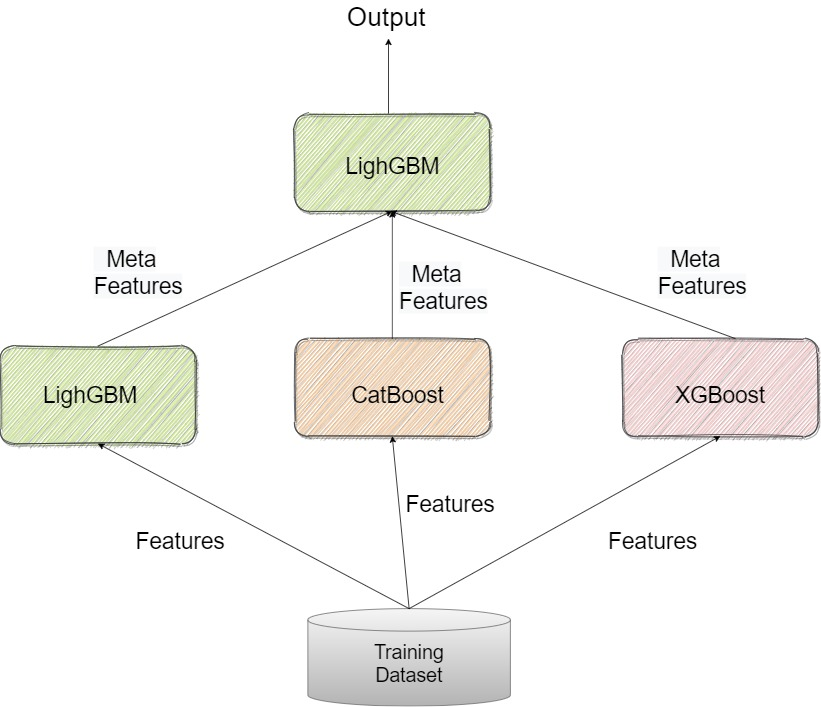

https://courses.analyticsvidhya.com/courses/ensemble-learning-and-ensemble-learning-techniques

In [ ]:
 av_metric(np.log1p(train[TARGET_COL]), lgb_oofs * 0.95 + cb_oofs * 0.05)

491.9977018575607

In [ ]:
train_new = train[[ID_COL, TARGET_COL]]
train_new[TARGET_COL] = np.log1p(train_new[TARGET_COL])

test_new = test[[ID_COL]]

train_new['lgb'] = lgb_oofs
test_new['lgb'] = lgb_preds

train_new['cb'] = cb_oofs
test_new['cb'] = cb_preds

train_new['xgb'] = xgb_oofs
test_new['xgb'] = xgb_preds

features = [c for c in train_new.columns if c not in [ID_COL, TARGET_COL]]

In [ ]:
clf = LinearRegression()

ens_oofs, ens_preds = run_clf_kfold(clf, train_new, test_new, features)


------------- Fold 1 -------------

AV metric score for validation set is 492.0430216124752

------------- Fold 2 -------------

AV metric score for validation set is 497.49864623745736

------------- Fold 3 -------------

AV metric score for validation set is 489.8007217209515

------------- Fold 4 -------------

AV metric score for validation set is 486.7438506218501

------------- Fold 5 -------------

AV metric score for validation set is 493.1531136878048


AV metric for oofs is 491.8608724360327


**Submitting on the Leaderboard**

In [ ]:
ens_preds_t = np.expm1(ens_preds)
download_preds(ens_preds, file_name = 'hacklive_ensemble_final.csv')